# Self-Driving Car Engineer Nanodegree

## Project 4: Advanced lane finding 

Note: Where sections are numbered the numbering follows the section numbering in the accompanying writeup.

### Prelude

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from tqdm import tqdm_notebook as tqdm
from pprint import pformat
from distutils.version import StrictVersion

%matplotlib inline

print("OpenCV version:", cv2.__version__)

if StrictVersion(cv2.__version__) < StrictVersion("3.1.0"):
    print("ERROR: OpenCV version 3.1.0 or greater required.")
    del cv2

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
matplotlib.rc('figure', figsize=(14, 7))

OpenCV version: 3.1.0


### B. Camera calibration

In [2]:
def load_images(image_paths):
    """Load images into memory as numpy arrays.
    Args:
        image_paths: An iterable of image paths (strings)
    Returns:
        [(path: string, image: ndarray)]: Where path is the image
        path and image is the ndarray containing the pixel data for 
        the loaded image.
    """
    return [(name, mpimg.imread(name)) for name in image_paths]

def get_img_size(img):
    """Return the X and Y size of a given image
    Args:
        img: The image whose dimensions need to be returned.
    Returns:
        (X: int, Y: int): The X and Y dimensions of `img`
    """
    return (img.shape[1], img.shape[0])

def get_camera_cal(cal_images, image_size, pattern_sizes):
    """Get the distortion coefficients required to undistort the
    images captured by a given camera.
    Args:
        cal_images: An iterable of images (ndarrays). A set of
        chessboard images which can be used to determine the camera 
        distortion coefficients.
        
        image_size: (X: int, Y:int): the X and Y size of the images
        
        pattern_sizes: [(rows: int, cols: int)] An iterable of 
        acceptable chessboard dimensions.
    
    Returns:
        Whatever `cv2.calibrateCamera()` returns!
    """
    # Find camera matrix and distortion parameters
    objpoints = [] # 3D Coordinates in real world space
    imgpoints = [] # 2D Coordinates in image plane

    # Prepare object points one for each accepted pattern size 
    objps = []
    for pattern_size in pattern_sizes:
        objp = np.zeros((np.prod(pattern_size), 3), np.float32)
        objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
        objps.append(objp)

    # Identify chess board corners in each input image and calculate its coordinates
    # in the image plane.
    for img_path, img in tqdm(cal_images):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret = None
        corners = None
        for pattern_size, objp in zip(pattern_sizes, objps):
            ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
                break
        if not ret:
            print("WARNING: Could not find chessboard corners in image:{} with pattern sizes:{}"
                  .format(img_path, pattern_sizes))
            plt.imshow(img)
            plt.show()

    return cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None, flags=cv2.CALIB_RATIONAL_MODEL)



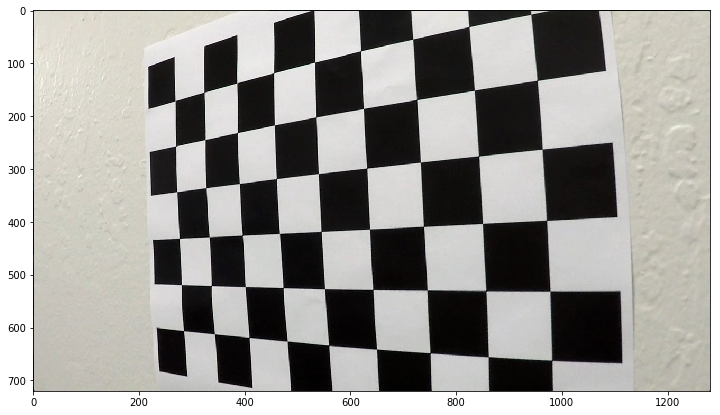

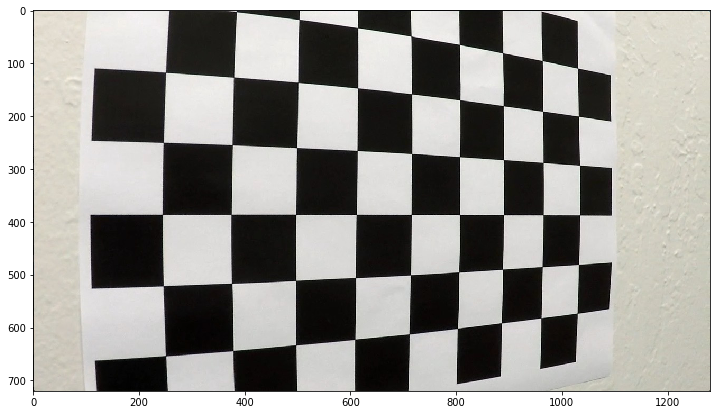


mtx:
 [[ 1165.102  0.000  644.724]
 [ 0.000  1162.629  390.100]
 [ 0.000  0.000  1.000]]
dist:
 [[-6.875  7.981 -0.000 -0.001  45.126 -6.464  4.181  56.017  0.000  0.000
   0.000  0.000  0.000  0.000]]


In [3]:
from glob import glob
cal1_img = mpimg.imread('camera_cal/calibration1.jpg')
cal1_img_shape = get_img_size(cal1_img)
cal_img_paths = glob('camera_cal/calibration*.jpg')
cal_images = load_images(cal_img_paths)
ret0, mtx0, dist0, rvecs0, tvecs0 = get_camera_cal(cal_images, 
                                                   cal1_img_shape, 
                                                   [(9,6), (9,5)])
if ret0:
    print("mtx:\n", mtx0)
    print("dist:\n", dist0)
else:
    print("ERROR: Could not get camera calibration.")


#### Sample distortion corrected calibration image (before and after)

Image shape: (720, 1280, 3)


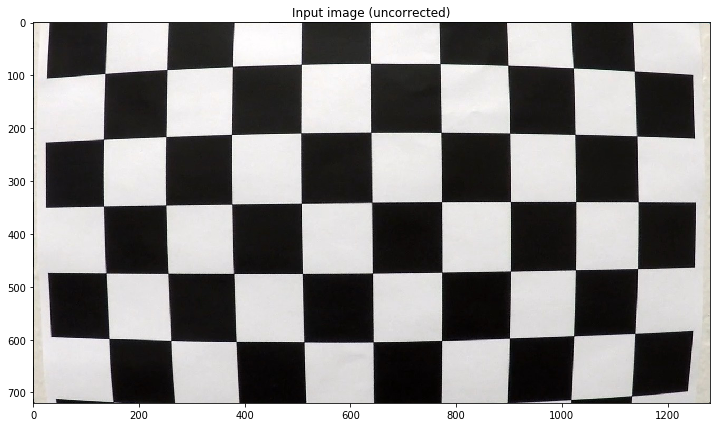

In [4]:
# Import chessboard image
img0 = mpimg.imread("camera_cal/calibration1.jpg")
print("Image shape:", img0.shape)
plt.title("Input image (uncorrected)")
plt.imshow(img0)
plt.savefig('output_images/distorted_chessboard.jpg')

In [5]:
def undistort(img):
    """Correct distortion in the input image using the distortion 
    coeffs calculated in a previous cell.
    """
    dst = cv2.undistort(img, mtx0, dist0, None, mtx0)
    return dst

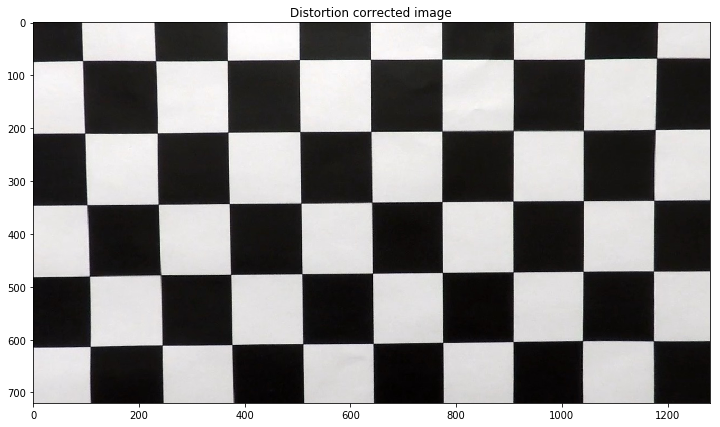

In [6]:
dst0 = undistort(img0)
plt.title("Distortion corrected image")
plt.imshow(dst0)
plt.savefig('output_images/undistorted_chessboard.jpg')

### C. Pipeline (test images)

#### C.1 Sample distortion corrected test image (before and after)

Image shape: (720, 1280, 3)


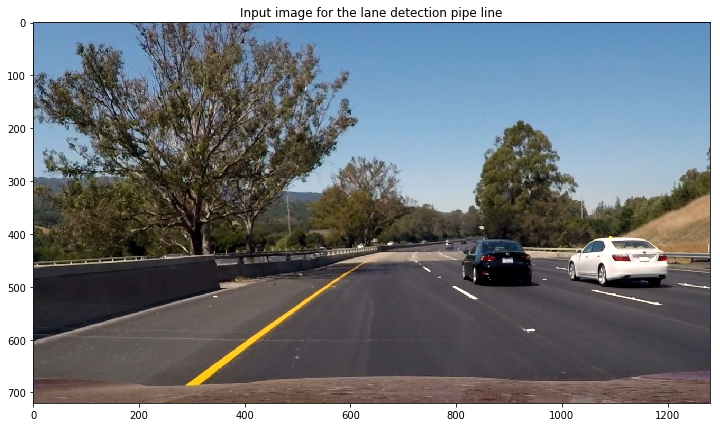

In [7]:
img1 = mpimg.imread("test_images/test6.jpg")
print("Image shape:", img1.shape)
plt.imshow(img1)
plt.title("Input image for the lane detection pipe line")
plt.savefig('output_images/distorted.jpg')

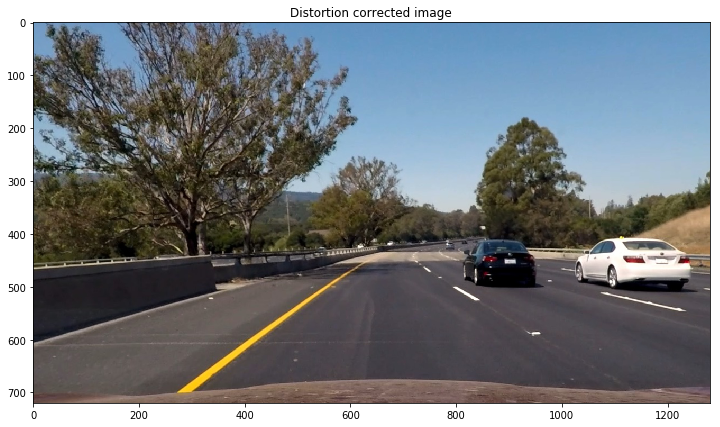

In [8]:
undst1 = undistort(img1)
plt.imshow(undst1)
plt.title("Distortion corrected image")
plt.savefig('output_images/undistorted.jpg')

#### C.2 Thresholded binary image

#### Edge detection (gradient detection along the X and Y axes)

In [9]:
def binarize(img, thresh_min, thresh_max):
    """Binarize the input image using the given thresholds.    
    """
    scaled_value_img = np.uint8(255 * img / np.max(img))
    sbinary = np.zeros_like(scaled_value_img)
    sbinary[(scaled_value_img >= thresh_min) & (scaled_value_img <= thresh_max)] = 1
    return sbinary

def sobel_x_y(img, ksize=9):
    """Run the Sobel filter in the X and Y direction on the 
    input image and return the resulting images as a tuple.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    return np.absolute(sobelx), np.absolute(sobely)

def sobel_mag_threshold(sobelx, sobely, thresh_min, thresh_max):
    """Return a binarized image created from the magnitude of 
    the Sobel filter applied in the X and Y direction (using 
    the given thresholds).
    """
    sobelm = np.sqrt(sobelx ** 2 + sobely ** 2)
    smbinary = binarize(sobelm, thresh_min, thresh_max)
    return smbinary

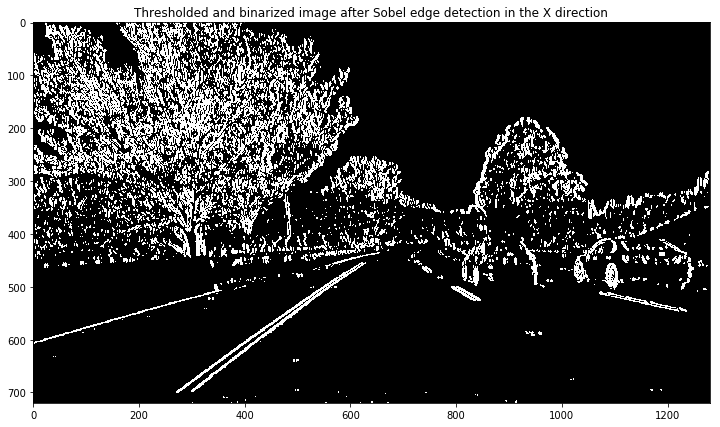

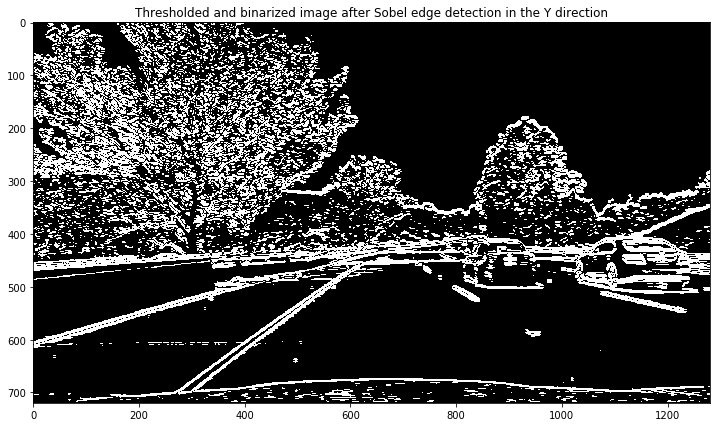

In [10]:
gray = cv2.cvtColor(undst1, cv2.COLOR_RGB2GRAY)
sobel_x, sobel_y = sobel_x_y(gray)
sobel_x_bin = binarize(sobel_x, 20, 255)
sobel_y_bin = binarize(sobel_y, 20, 255)

plt.title("Thresholded and binarized image after Sobel edge detection in the X direction")
plt.imshow(sobel_x_bin, cmap='gray')
plt.savefig('output_images/sobel_x_bin.jpg')

plt.show()

plt.title("Thresholded and binarized image after Sobel edge detection in the Y direction")
plt.imshow(sobel_y_bin, cmap='gray')
plt.savefig('output_images/sobel_y_bin.jpg')

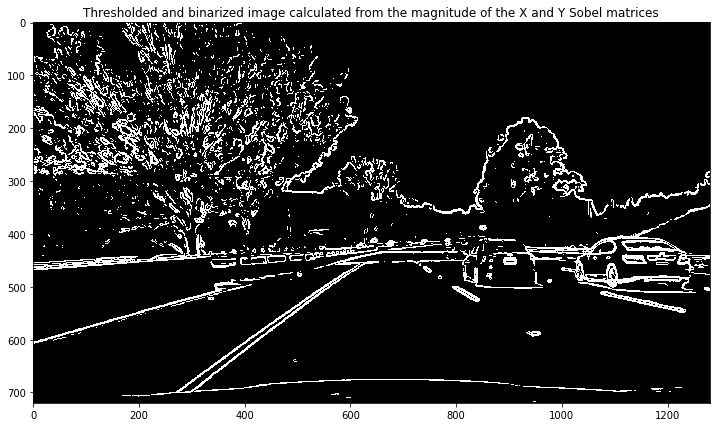

In [11]:
sobel_mag_bin = sobel_mag_threshold(sobel_x, sobel_y, 50, 255)

plt.title("Thresholded and binarized image calculated from the magnitude of the X and Y Sobel matrices")
plt.imshow(sobel_mag_bin, cmap='gray')
plt.savefig('output_images/sobel_mag_bin.jpg')

#### Thresholding by the direction of the gradient

In [12]:
def sobel_grad_dir_threshold(sobelx, sobely, thresh_min, thresh_max):
    """Return a binarized image created from the direction of the 
    gradient calculated from the Sobel filter applied in the X and 
    Y directions (using the given thresholds, the threshold values 
    must be specified in degrees (and not radians)).
    """
    gradient_dirs = np.absolute(np.arctan2(sobelx, sobely))
    binary = np.zeros_like(gradient_dirs)
    thresh_min = thresh_min/180 * np.pi
    thresh_max = thresh_max/180 * np.pi
    binary[(gradient_dirs >= thresh_min) & (gradient_dirs <= thresh_max)] = 1
    return binary

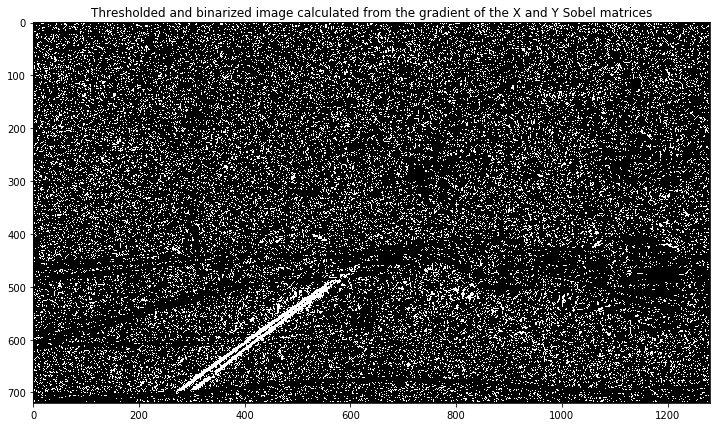

In [13]:
gradient_dir_bin = sobel_grad_dir_threshold(sobel_x, sobel_y, 30, 45)

plt.title("Thresholded and binarized image calculated from the gradient of the X and Y Sobel matrices")
plt.imshow(gradient_dir_bin, cmap='gray')
plt.savefig('output_images/gradient_dir_bin.jpg')

#### Combining thresholds

In [14]:
def threshold_1ch_image(img, mt, gdt, ksize):
    """Apply sobel_mag_threshold() and sobel_grad_dir_threshold() to a
    2D input image and return its conjunction.
    """
    assert len(img.shape) == 2
    sobel_x, sobel_y = sobel_x_y(img, ksize=ksize)
    sobel_mag_bin = sobel_mag_threshold(sobel_x, sobel_y, mt[0], mt[1])
    gradient_dir_bin = sobel_grad_dir_threshold(sobel_x, sobel_y, gdt[0], gdt[1])
    combined = np.zeros_like(gradient_dir_bin)
    combined[((sobel_mag_bin == 1) & (gradient_dir_bin == 1))] = 1
    return combined

def threshold_3ch_image(img, mt=(50, 255), gdt=(30, 45), ksize=31):
    """Take a color input image and convert it into a 2D gray scale image and 
    a 2D image with only the saturation channel from the HLS color space and 
    run them through the thresholding pipeline `threshold_1ch_image()`. Return
    the disjunction of the thresholded images."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_sat = hls[:,:,2]

    thresholded = threshold_1ch_image(gray, mt, gdt, ksize)
    color_sat_thresholded = threshold_1ch_image(color_sat, mt, gdt, ksize)
    # Merge color_sat_thresholded into thresholded
    thresholded[color_sat_thresholded == 1] = 1
    return thresholded

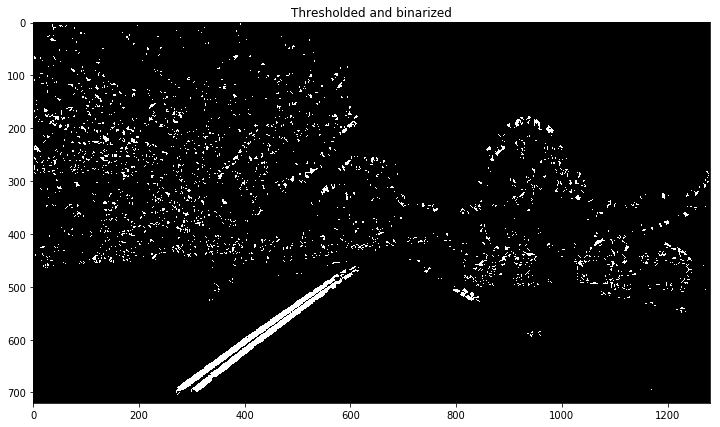

In [15]:
thresholded = threshold_3ch_image(undst1)
plt.title("Thresholded and binarized")
plt.imshow(thresholded, cmap='gray')
plt.savefig('output_images/thresholded.jpg')
plt.show()

#### C.3 Bird's eye view of a sample image using perspective transform

In [16]:
import math

def get_prespective_matrix_and_src_coords(x_offset):
    """Get the prespective matrix, inverse perspective matrixm, source 
    and dest coordinates for the perspective transform. x_offset can be 
    used to move the offset the lane in the destination image if required."""
    src_coords = np.float32([
        [206, 719],
        [579, 462],
        [704, 462],
        [1103, 719]
    ])
    # The source coordinates form a trapezoidal shape in the source image.
    # `hyp` is the estimated length of the non parallel sides (both assumed to be equal 
    # to eachother). It is assumed this trapezoid will change into
    # a rectangle with the size of the far side equal to the size of the near side
    # and the non-parallel sides parallel to each other but retaining their
    # original size once transformed into the destination image.
    hyp = int(math.sqrt((src_coords[0][1] - src_coords[1][1])**2 
                      + (src_coords[1][0] - src_coords[0][0])**2))
    hyp = 719 - hyp
    
    dst_coords = np.float32([
        [src_coords[0][0]-x_offset, src_coords[0][1]],
        [src_coords[0][0]-x_offset, hyp],
        [src_coords[3][0]-x_offset, hyp],
        [src_coords[3][0]-x_offset, src_coords[3][1]]
    ])
    
    perspective_mtx = cv2.getPerspectiveTransform(src_coords, dst_coords)
    inv_perspective_mtx = cv2.getPerspectiveTransform(dst_coords, src_coords)
    return perspective_mtx, inv_perspective_mtx, src_coords, dst_coords
    

In [17]:
perspective_mtx, inv_perspective_mtx, \
perspective_src_coords, perspective_dest_coords = get_prespective_matrix_and_src_coords(0)


In [18]:
def apply_perspective_transform(img, pmtx, x_scale, y_scale):
    ydim, xdim = img.shape[:2]
    warped = cv2.warpPerspective(img, pmtx, 
                                 (int(xdim*x_scale), int(ydim*y_scale)), 
                                 flags=cv2.INTER_LINEAR)    
    return warped

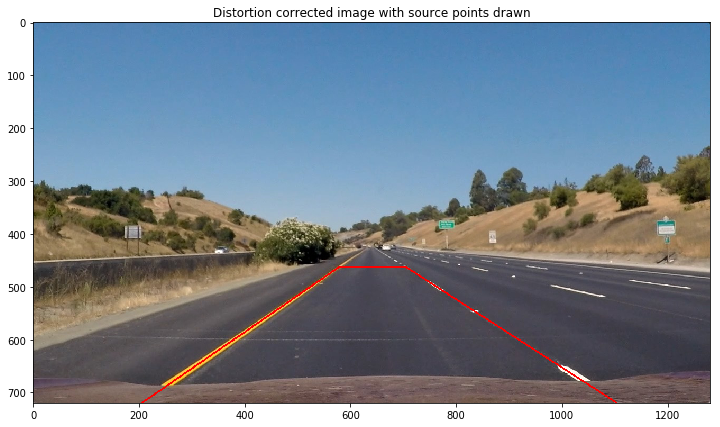

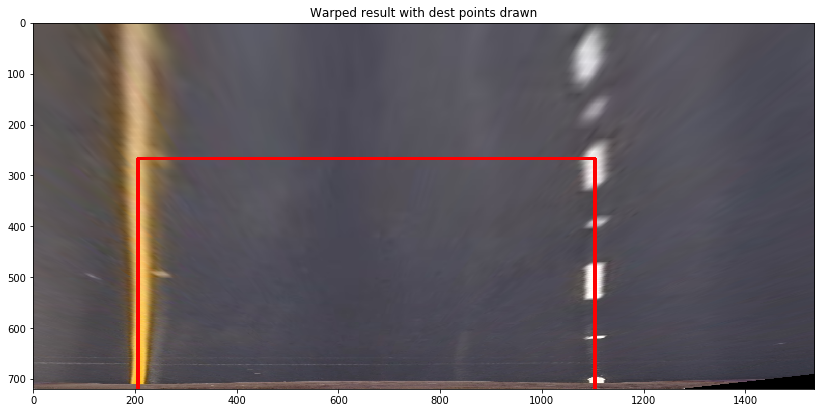

In [19]:
t_img = mpimg.imread("test_images/straight_lines1.jpg")
pt_img = apply_perspective_transform(t_img, perspective_mtx, 1.2, 1)

cv2.polylines(t_img, [np.int32(perspective_src_coords)], False, (255, 0, 0), 2)
plt.title("Distortion corrected image with source points drawn")
plt.imshow(t_img)
plt.savefig('output_images/pre_warp.jpg')
plt.show()

cv2.polylines(pt_img, [np.int32(perspective_dest_coords)], False, (255, 0, 0), 6)
plt.title("Warped result with dest points drawn")
plt.imshow(pt_img)
plt.savefig('output_images/warped.jpg')
plt.show()

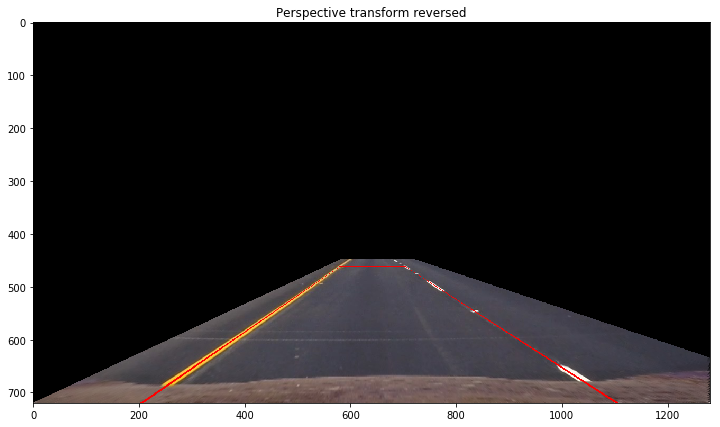

In [20]:
pti_img = apply_perspective_transform(pt_img, inv_perspective_mtx, 1/1.2, 1)
plt.imshow(pti_img)
plt.title("Perspective transform reversed")
plt.savefig('output_images/unwarped.jpg')
plt.show()

#### C4. Identify lane lines

In [21]:
def make_3ch(img):
    """Convert a single channel image into a three channel image."""
    return np.repeat(img[...,None], 3 ,axis=2)

def maximize_dynamic_range(img):
    """Normalize an image into the [0, 255] pixel value range"""
    return np.uint8(255 * img / np.max(img))

def get_histogram(img):
    """Get an histogram of the sum of columns of the lower half of the input image"""
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

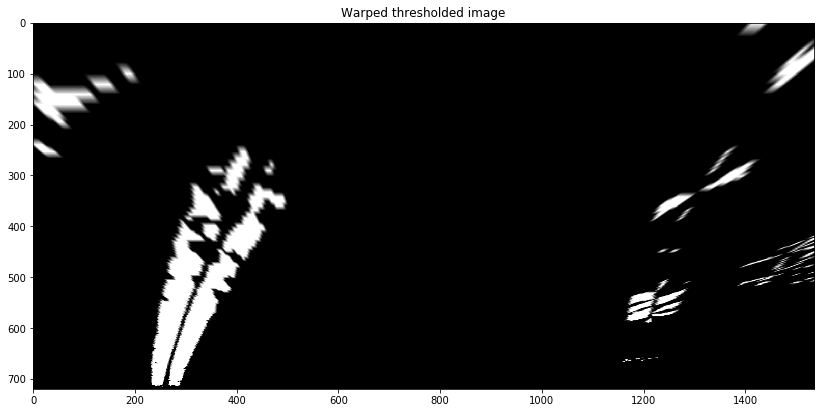

In [22]:
warped_thresholded = apply_perspective_transform(thresholded, perspective_mtx, 1.2, 1)
plt.title("Warped thresholded image")
plt.imshow(warped_thresholded, cmap='gray')
plt.savefig('output_images/warped_thresholded.jpg')
plt.show()

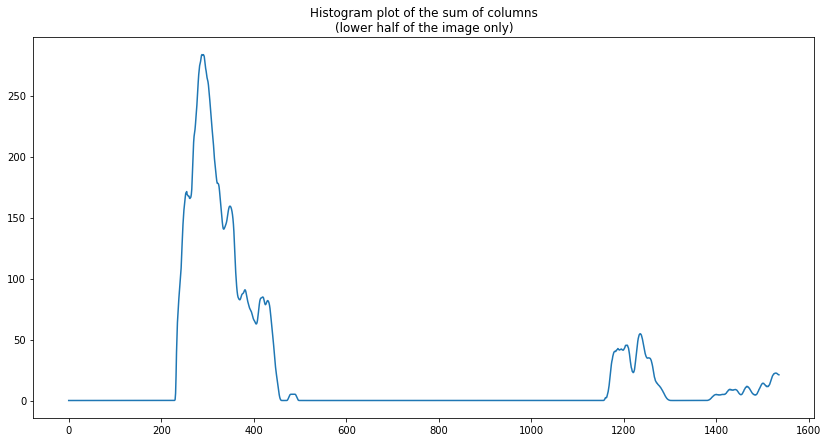

In [23]:
histogram = get_histogram(warped_thresholded)
plt.plot(histogram)
plt.title("Histogram plot of the sum of columns\n(lower half of the image only)")
plt.savefig('output_images/histogram.jpg')

In [24]:
# Adapted from Udacity sample code
def detect_lane_boundaries(img):
    img_y_size, img_x_size  = img.shape
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)
    # `histogram` is a one dimensional array where each element represents
    # the sum of the column at its own index for the lower half of the image
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img_y_size//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 150
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_y_size - (window+1)*window_height
        win_y_high = img_y_size - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [25]:
# Adapted from Udacity sample code
def rasterize_lane_boundaries(ydim, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, ydim-1, ydim )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

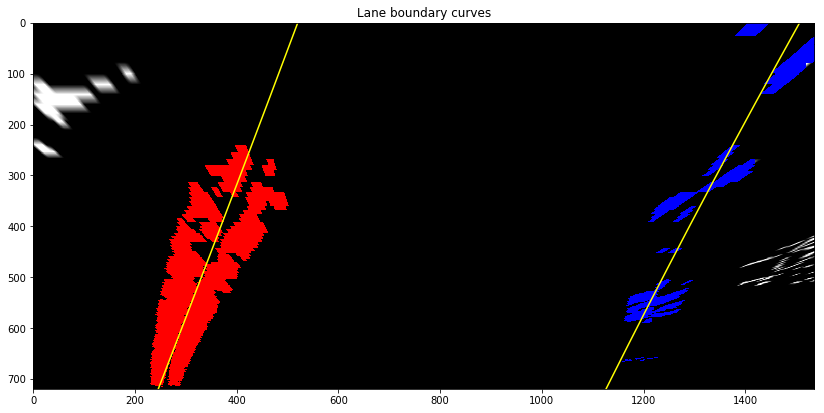

In [26]:
# Adapted from Udacity sample code
def show_boundary_curves(warped):
    left_fit, right_fit, leftx, lefty, rightx, righty  = detect_lane_boundaries(warped)
    ydim, xdim = warped.shape[:2]

    ploty, left_fitx, right_fitx = rasterize_lane_boundaries(ydim, left_fit, right_fit)

    # Create an output image to draw on and  visualize the result
    out_img = make_3ch(warped)
    out_img[lefty, leftx] = [1, 0, 0]
    out_img[righty, rightx] = [0, 0, 1]
    plt.title("Lane boundary curves")
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.savefig('output_images/lane_boundary_curves.jpg')
    plt.show()
show_boundary_curves(warped_thresholded)

### D. Pipeline (Video)

In [27]:
def display_text(img, lines, x=0, y=0, vspacing=10, font=cv2.FONT_HERSHEY_SIMPLEX, color=(255, 255, 255), scale=1, thickness=1):
    """Print given lines on the input image at the specified coordinates with the sepecified options."""
    for line in lines:
        (w, h), _ = cv2.getTextSize(line, font, scale, thickness)
        y += h
        cv2.putText(img, line, (x, y), font, scale, color, thickness)
        y += vspacing

In [28]:
# Adapted from Udacity sample code
def get_radius_of_curvature(ymax, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space so that the 
    # returned coeffs represent a curve in the world space.
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = ymax
    
    # Calculate the new radii of curvature using the radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad


In [29]:
def get_center_offset(xdim, ydim, left_fitx, right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Get the x-coord of the center of the image. This is the x-coord of the center of the car.
    center = xdim // 2
    
    # Get the y-coord of the last line in the image.
    ymax = ydim - 1
    
    # Get the x-coord of the left lane in the last line of the image.
    leftx = left_fitx[ymax]
    
    # Get the x-coord of the right lane in the last line of the image.
    rightx = right_fitx[ymax]
    
    # Calculate the x-coord of the center of the lane in the last line of the image.
    lane_center = (rightx - leftx) // 2 + leftx
    
    # The offset is the difference of these center coords.
    offset = lane_center - center
    
    # Scale the pixel value to estimated real world dimensions
    return offset * xm_per_pix

In [30]:
# Adapted from Udacity sample code
def annotate_lane(img, perspective_mtx, inv_perspective_mtx, xscale=1.2):
    undist = undistort(img)
    thresholded = threshold_3ch_image(undist)
    warped = apply_perspective_transform(thresholded, perspective_mtx, xscale, 1)
    warped = maximize_dynamic_range(warped)
    
    left_fit, right_fit, leftx, lefty, rightx, righty = detect_lane_boundaries(warped)
        
    ploty, left_fitx, right_fitx = rasterize_lane_boundaries(warped.shape[0], left_fit, right_fit)
        
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    warped_color_mask = make_3ch(warp_zero)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_color_mask, np.int_([pts]), (0, 255, 0))

    # Unwarp the blank back to original image space using inverse perspective matrix
    unwarped_color_mask = apply_perspective_transform(warped_color_mask, inv_perspective_mtx, 1/xscale, 1)
    ydim, xdim, _ = unwarped_color_mask.shape
    
    # Get radius of curvature
    curv_radius_l, curv_radius_r = get_radius_of_curvature(ydim-1, leftx, lefty, rightx, righty)
    
    # Get vehicle offset from lane center
    offset = get_center_offset(xdim, ydim, left_fitx, right_fitx)

    # Display radius of curvature and vehicle offset information on the output image mask.
    info = []
    info.append("Left radius of curvature : {:.0f}m".format(curv_radius_l))
    info.append("Right radius of curvature : {:.0f}m".format(curv_radius_r))
    info.append("Vehicle is {:.2f}m left of center".format(offset))
    
    display_text(unwarped_color_mask, info, y=10)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, unwarped_color_mask, 0.3, 0)
    return result


In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img = annotate_lane(img, perspective_mtx, inv_perspective_mtx)
    return img

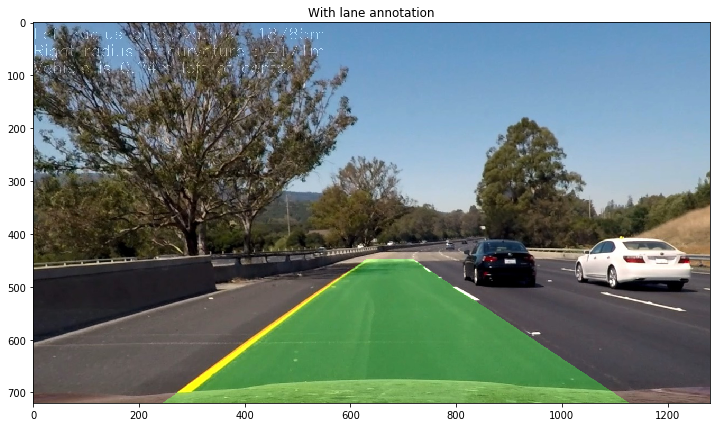

In [33]:
annotated = process_image(img1)
plt.title("With lane annotation")
plt.imshow(annotated)
plt.savefig("output_images/annotated.jpg")

In [34]:
# Adapted from Udacity sample code
import os
if not os.path.exists('output_videos'):
    os.makedirs('output_videos')

project_output = 'output_videos/project_video_annotated.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
# clip1.save_frame("untracked/output_videos/first.jpg")

In [35]:
clip1_1 = clip1.fl_image(process_image) # NOTE: this function expects color images!!
%time clip1_1.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_annotated.mp4
[MoviePy] Writing video output_videos/project_video_annotated.mp4


100%|█████████▉| 1260/1261 [17:37<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_annotated.mp4 

CPU times: user 17min 19s, sys: 3.16 s, total: 17min 22s
Wall time: 17min 40s


Play the video inline, or if you prefer find the video in your filesystem and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video.mp4"))

In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))